# An example of reference mapping using user-owned reference dataset

In [1]:
import numpy as np
import scanpy as sc
import sys
import os
import warnings
import torch
from pathlib import Path
import json
import pandas as pd
from scipy.stats import mode

import torch

print(torch.__version__)

2.2.0


In [2]:
# extra dependency for similarity search
try:
    import hnswlib

    hnswlib_imported = True
except ImportError:
    hnswlib_imported = False
    print(
        "hnswlib not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, run: pip install hnswlib")

sys.path.insert(0, "../")

In [3]:
from scgpt.loss import masked_mse_loss, masked_relative_error
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt import logger
from scgpt import SubsetsBatchSampler
import sklearn

/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## some  functions

In [4]:
def get_batch_cell_embeddings(
    adata,
    cell_embedding_mode: str = "cls",
    model=None,
    vocab=None,
    max_length=1200,
    model_configs=None,
    gene_ids=None,
    use_batch_labels=False,
) -> np.ndarray:
    """
    Get the cell embeddings for a batch of cells.

    Args:
        adata (AnnData): The AnnData object.
        gene_embs (np.ndarray): The gene embeddings, shape (len(vocab), d_emb).
        count_matrix (np.ndarray): The count matrix.

    Returns:
        np.ndarray: The cell embeddings.
    """
    count_matrix = (
        adata.layers["counts"]
        if isinstance(adata.layers["counts"], np.ndarray)
        else adata.layers["counts"].A
    )
    
    # Ensure count_matrix is a proper numpy array with copy to avoid issues
    count_matrix = np.array(count_matrix, dtype=np.float32)

    # gene vocabulary ids
    if gene_ids is None:
        gene_ids = np.array(adata.var["id_in_vocab"])
        assert np.all(gene_ids >= 0)
    
    # Ensure gene_ids is a proper numpy array
    gene_ids = np.array(gene_ids, dtype=np.int64)

    if use_batch_labels:
        batch_ids = np.array(adata.obs["batch_id"].tolist())

    elif cell_embedding_mode == "cls":
        tokenized_all = tokenize_and_pad_batch(
            count_matrix,
            gene_ids,
            max_len=max_length,
            vocab=vocab,
            pad_token=model_configs["pad_token"],
            pad_value=model_configs["pad_value"],
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=False,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[model_configs["pad_token"]])
        # Disable CUDA AMP since we're using CPU on Mac
        with torch.no_grad():
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=8,
                batch_labels=None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )
    else:
        raise ValueError(f"Unknown cell embedding mode: {cell_embedding_mode}")
    return cell_embeddings

In [ ]:
adata_dict = {}

folder = "/Users/vedran/Documents/scpgpt-project/"

for dset in [
    "251020_blood_atlas.h5ad",
    "251020_mann2017.h5ad",
    "251020_monaco.h5ad",
    "251020_schmiedel.h5ad",
]:
    adata = sc.read_h5ad(
        # "/Users/vedran/Downloads/251020_blood_atlas.h5ad"
        folder + dset
    )
    cell_type_key = "cell_type"
    assert cell_type_key in adata.obs

    gene_col = "index"
    if gene_col == "index":
        adata.var["index"] = adata.var.index
    else:
        assert gene_col in adata.var

    adata_dict[dset] = adata

adata_dict.keys()


dict_keys(['251020_blood_atlas.h5ad', '251020_mann2017.h5ad', '251020_monaco.h5ad', '251020_schmiedel.h5ad'])

In [8]:
adata_dict

{'251020_blood_atlas.h5ad': AnnData object with n_obs × n_vars = 153 × 9202
     obs: 'cell_type', 'lineage'
     var: 'n_cells', 'index',
 '251020_mann2017.h5ad': AnnData object with n_obs × n_vars = 100 × 9317
     obs: 'cell_type', 'lineage'
     var: 'n_cells', 'index',
 '251020_monaco.h5ad': AnnData object with n_obs × n_vars = 18 × 17514
     obs: 'cell_type', 'lineage'
     var: 'n_cells', 'index',
 '251020_schmiedel.h5ad': AnnData object with n_obs × n_vars = 10 × 15272
     obs: 'cell_type', 'lineage'
     var: 'n_cells', 'index'}

In [9]:
n_hvg = max_seq_len = 1200
DO_HVG = True
HAS_BATCH = batch_key = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Load model vocabulary and configuration
model_dir = Path(folder + "/scGPT")  # Update this path to your model directory
vocab_file = model_dir / "vocab.json"
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]

# Load vocabulary
vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

vocab.set_default_index(vocab["<pad>"])

# Load model configuration
with open(model_config_file, "r") as f:
    model_configs = json.load(f)

In [12]:
for dset in adata_dict:
    print(dset)
    adata = adata_dict[dset]
    # Match genes to vocabulary
    adata.var["id_in_vocab"] = [
        vocab[gene] if gene in vocab else -1 for gene in adata.var[gene_col]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0] # what does it mean?

    adata_dict[dset] = adata
    print()

251020_blood_atlas.h5ad
scGPT - INFO - match 9142/9202 genes in vocabulary of size 60697.

251020_mann2017.h5ad
scGPT - INFO - match 8621/9317 genes in vocabulary of size 60697.

251020_monaco.h5ad
scGPT - INFO - match 17068/17514 genes in vocabulary of size 60697.

251020_schmiedel.h5ad
scGPT - INFO - match 15113/15272 genes in vocabulary of size 60697.



In [13]:
model = TransformerModel(
    ntoken=len(vocab),
    d_model=model_configs["embsize"],
    nhead=model_configs["nheads"],
    d_hid=model_configs["d_hid"],
    nlayers=model_configs["nlayers"],
    nlayers_cls=model_configs["n_layers_cls"],
    n_cls=1,
    vocab=vocab,
    dropout=model_configs["dropout"],
    pad_token=model_configs["pad_token"],
    pad_value=model_configs["pad_value"],
    do_mvc=True,
    do_dab=False,
    use_batch_labels=False,
    # num_batch_labels=num_batch_types,
    domain_spec_batchnorm=False,
    explicit_zero_prob=False,
    use_fast_transformer=True,
    fast_transformer_backend="flash",
    pre_norm=False,
)

# Load the checkpoint
checkpoint = torch.load(model_file, map_location=device)

# Handle naming differences between PyTorch 1.x and 2.x Transformer layers
state_dict = checkpoint

# Map "Wqkv" -> "in_proj_weight"/"in_proj_bias" if needed
mapped_state_dict = {}
for k, v in state_dict.items():
    if "Wqkv.weight" in k:
        base = k.replace("Wqkv.weight", "")
        # Split Wqkv.weight into in_proj_weight format if possible
        mapped_state_dict[base + "in_proj_weight"] = v
    elif "Wqkv.bias" in k:
        base = k.replace("Wqkv.bias", "")
        mapped_state_dict[base + "in_proj_bias"] = v
    else:
        mapped_state_dict[k] = v

# Load model parameters, ignoring missing/unexpected keys safely
model_dict = model.state_dict()
pretrained_dict = {
    k: v for k, v in mapped_state_dict.items()
    if k in model_dict and v.shape == model_dict[k].shape
}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict, strict=False)

model.to(device)
model.eval()

/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

In [14]:
embeddings_dict = {}

for dset in adata_dict:
    print(dset)
    adata = adata_dict[dset]

    data_is_raw = adata.X.max() > 30
    print("data is raw: ", data_is_raw)
    preprocessor = Preprocessor(
        use_key="X",  # the key in adata.layers to use as raw data
        filter_gene_by_counts=False,  # step 1
        filter_cell_by_counts=False,  # step 2
        normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
        result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
        log1p=data_is_raw,  # 4. whether to log1p the normalized data
        result_log1p_key="X_log1p",
        subset_hvg=n_hvg if DO_HVG else False,
        hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
        binning=51,  # 6. whether to bin the raw data and to what number of bins
        result_binned_key="counts",  # the key in adata.layers to store the binned data
    )
    preprocessor(adata, batch_key=batch_key if HAS_BATCH else None)

    # Get gene IDs for the preprocessed genes
    genes = adata.var[gene_col].tolist()
    gene_ids = np.array(vocab(genes), dtype=int)
    print(len(genes), len(gene_ids))
    
    if HAS_BATCH: # None
        adata.obs["batch_id"] = adata.obs[batch_key].astype("category").cat.codes.values
    else:
        adata.obs["batch_id"] = adata.obs[cell_type_key].astype("category").cat.codes.values
    batch_ids = adata.obs["batch_id"].tolist()
    num_batch_types = len(set(batch_ids))
    batch_ids = np.array(batch_ids)
    
    # Tokenize input # What is it?
    if isinstance(adata.layers["counts"], np.ndarray):
        all_counts = adata.layers["counts"]
    else:
        all_counts = adata.layers["counts"].A
    
    num_of_non_zero_genes = [np.count_nonzero(all_counts[i]) for i in range(all_counts.shape[0])]
    
    max_length = np.max(num_of_non_zero_genes) + 1  # plus 1 for appending <cls>
    print(max_length, max_seq_len + 1)
    max_length = min(max_length, max_seq_len + 1)
    print(max_length, "\n")


    ref_cell_embeddings = get_batch_cell_embeddings(
        adata,
        cell_embedding_mode="cls",
        model=model,
        vocab=vocab,
        max_length=max_length,
        model_configs=model_configs,
        gene_ids=gene_ids,
        use_batch_labels=False,
    )

    embeddings_dict[dset] = ref_cell_embeddings

    print()

251020_blood_atlas.h5ad
data is raw:  True
scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...
1200 1200
874 1201
874 



/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
  0%|          | 0/20 [00:00<?, ?it/s]/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:179.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


251020_mann2017.h5ad
data is raw:  True
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...



/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


1200 1200
956 1201
956 



100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


251020_monaco.h5ad
data is raw:  True
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...



/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


1200 1200
1191 1201
1191 



100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


251020_schmiedel.h5ad
data is raw:  True
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...



/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


1200 1200
1142 1201
1142 



100%|██████████| 2/2 [00:03<00:00,  1.61s/it]

In [15]:
adata.obs["cell_type"].astype("category")

CD4_MemoryTfh_01                    CD4_MemoryTfh
CD4_MemoryTh1_01                    CD4_MemoryTh1
CD4_MemoryTh17_01                  CD4_MemoryTh17
CD4_MemoryTh2_01                    CD4_MemoryTh2
NK_Dim_01                                  NK_Dim
Monocyte_Classical_01          Monocyte_Classical
B_Naive_01                                B_Naive
CD4_Naive_01                            CD4_Naive
CD8_Naive_01                            CD8_Naive
Monocyte_Nonclassical_01    Monocyte_Nonclassical
Name: cell_type, dtype: category
Categories (10, object): ['B_Naive', 'CD4_MemoryTfh', 'CD4_MemoryTh1', 'CD4_MemoryTh17', ..., 'CD8_Naive', 'Monocyte_Classical', 'Monocyte_Nonclassical', 'NK_Dim']

In [16]:
embeddings_dict

{'251020_blood_atlas.h5ad': array([[ 0.00104369, -0.00139252,  0.00188184, ..., -0.01444907,
         -0.00143549,  0.00783853],
        [-0.00372388, -0.0008031 , -0.00043768, ..., -0.01656131,
         -0.00373755,  0.00831427],
        [-0.00252717, -0.00338656,  0.00086454, ..., -0.01496986,
         -0.00225814,  0.00784601],
        ...,
        [-0.00801858,  0.00047167, -0.01154283, ..., -0.00056591,
         -0.00092214,  0.01201131],
        [-0.00613719,  0.00217711, -0.00765942, ..., -0.00336333,
          0.00118759,  0.01410622],
        [-0.00018939,  0.00682399, -0.00686362, ..., -0.00607345,
          0.00732896,  0.0125218 ]], dtype=float32),
 '251020_mann2017.h5ad': array([[-0.01295731, -0.00117499, -0.02229477, ..., -0.00484973,
         -0.00535697, -0.00447811],
        [-0.00746967,  0.00058746, -0.01917283, ..., -0.00634821,
         -0.00197723,  0.00331352],
        [-0.00627333,  0.00288463, -0.01869816, ..., -0.00130173,
          0.00222144, -0.0040453 ],
 

In [17]:
all_embeddings = [embeddings_dict[k] for k in embeddings_dict]
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_embeddings.shape

(281, 512)

In [18]:
adata_dict

{'251020_blood_atlas.h5ad': AnnData object with n_obs × n_vars = 153 × 1200
     obs: 'cell_type', 'lineage', 'batch_id'
     var: 'n_cells', 'index', 'id_in_vocab', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'log1p', 'hvg'
     obsm: 'bin_edges'
     layers: 'X_normed', 'X_log1p', 'counts',
 '251020_mann2017.h5ad': AnnData object with n_obs × n_vars = 100 × 1200
     obs: 'cell_type', 'lineage', 'batch_id'
     var: 'n_cells', 'index', 'id_in_vocab', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'log1p', 'hvg'
     obsm: 'bin_edges'
     layers: 'X_normed', 'X_log1p', 'counts',
 '251020_monaco.h5ad': AnnData object with n_obs × n_vars = 18 × 1200
     obs: 'cell_type', 'lineage', 'batch_id'
     var: 'n_cells', 'index', 'id_in_vocab', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'log1p', 'hvg'
     obsm: 'bin_edges'
     layers: 'X_normed', 'X_l

In [19]:
import anndata as ad

In [20]:
combined = ad.concat(adata_dict.values(), axis=0, join="outer")
combined

/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 281 × 2736
    obs: 'cell_type', 'lineage', 'batch_id'
    obsm: 'bin_edges'
    layers: 'X_normed', 'X_log1p', 'counts'

In [21]:
combined.obs

,cell_type,lineage,batch_id
Basophil_01,Basophil,Granulocyte,2
Basophil_02,Basophil,Granulocyte,2
Basophil_03,Basophil,Granulocyte,2
Basophil_04,Basophil,Granulocyte,2
Basophil_05,Basophil,Granulocyte,2
...,...,...,...
Monocyte_Classical_01,Monocyte_Classical,Monocyte,7
B_Naive_01,B_Naive,B_Cell,0
CD4_Naive_01,CD4_Naive,T_CD4,5
CD8_Naive_01,CD8_Naive,T_CD8,6


In [22]:
adata_dict

{'251020_blood_atlas.h5ad': AnnData object with n_obs × n_vars = 153 × 1200
     obs: 'cell_type', 'lineage', 'batch_id'
     var: 'n_cells', 'index', 'id_in_vocab', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'log1p', 'hvg'
     obsm: 'bin_edges'
     layers: 'X_normed', 'X_log1p', 'counts',
 '251020_mann2017.h5ad': AnnData object with n_obs × n_vars = 100 × 1200
     obs: 'cell_type', 'lineage', 'batch_id'
     var: 'n_cells', 'index', 'id_in_vocab', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'log1p', 'hvg'
     obsm: 'bin_edges'
     layers: 'X_normed', 'X_log1p', 'counts',
 '251020_monaco.h5ad': AnnData object with n_obs × n_vars = 18 × 1200
     obs: 'cell_type', 'lineage', 'batch_id'
     var: 'n_cells', 'index', 'id_in_vocab', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'log1p', 'hvg'
     obsm: 'bin_edges'
     layers: 'X_normed', 'X_l

/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


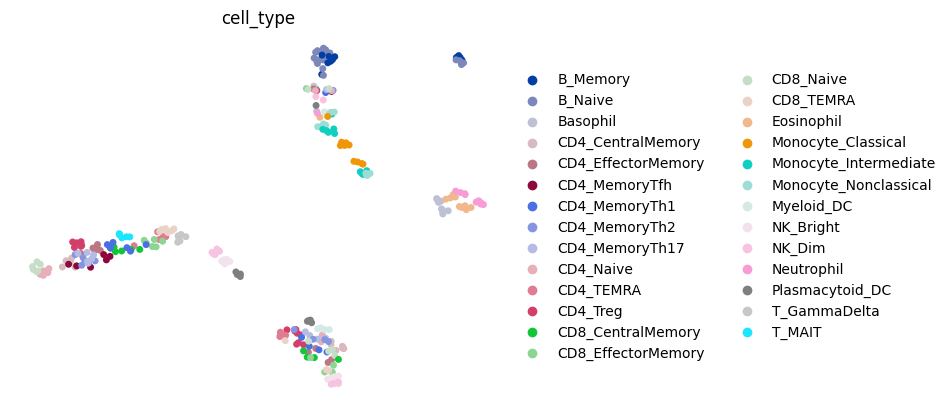

In [42]:
# Optional step to visualize the reference dataset using the embeddings
ref_embed_adata = sc.AnnData(all_embeddings, obs=pd.DataFrame(combined.obs))

sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)

sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4, size=100)

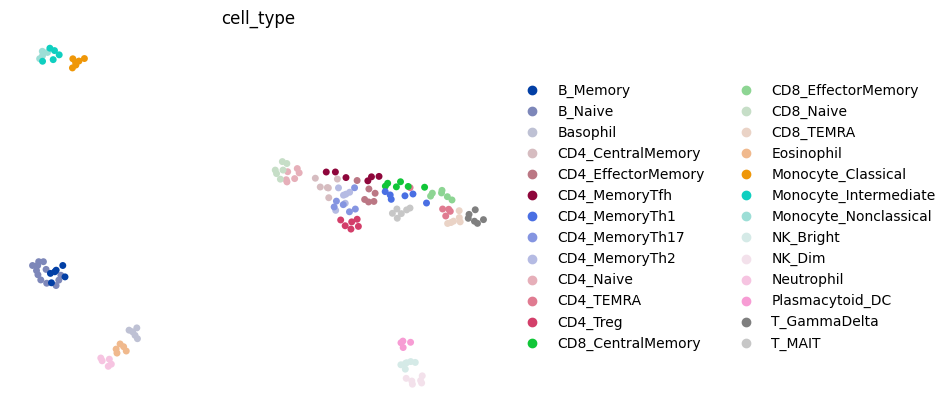

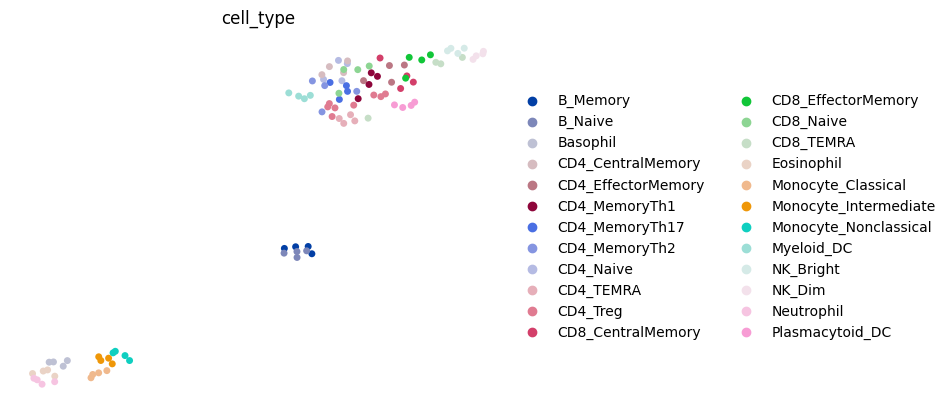

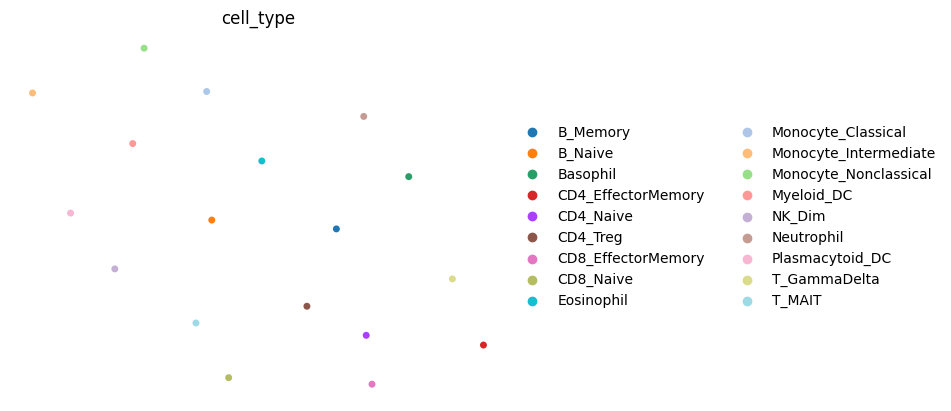

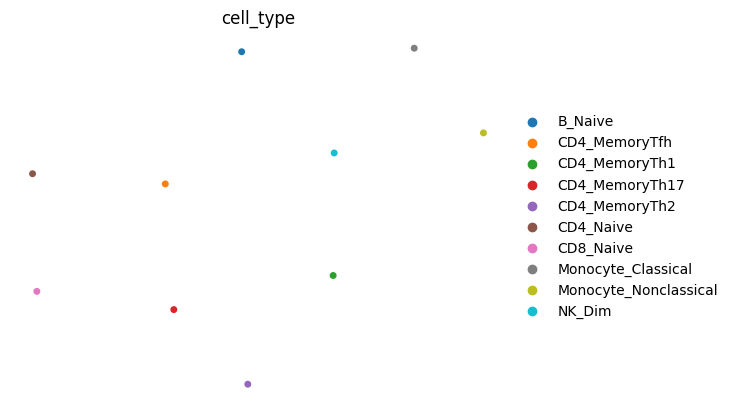

In [24]:
for dset in adata_dict:
    adata = adata_dict[dset]
    embeddings = embeddings_dict[dset]

    # Optional step to visualize the reference dataset using the embeddings
    ref_embed_adata = sc.AnnData(embeddings, obs=pd.DataFrame(adata.obs))
    
    sc.pp.neighbors(ref_embed_adata, use_rep="X")
    sc.tl.umap(ref_embed_adata)

    sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4, size=100)

In [25]:
adata

AnnData object with n_obs × n_vars = 10 × 1200
    obs: 'cell_type', 'lineage', 'batch_id'
    var: 'n_cells', 'index', 'id_in_vocab', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    obsm: 'bin_edges'
    layers: 'X_normed', 'X_log1p', 'counts'

In [26]:
ref_cell_embeddings

array([[-7.5968718e-03,  1.2002630e-02, -6.6698335e-02, ...,
        -2.2581911e-02,  1.5824968e-04, -2.0893022e-02],
       [-7.4500730e-03,  2.1286936e-02, -5.9264269e-02, ...,
        -1.7009845e-02, -4.5796717e-03, -1.4005824e-02],
       [-4.7866954e-03,  2.3749525e-02, -6.2723018e-02, ...,
        -1.8078204e-02, -3.1026897e-03, -1.5106860e-02],
       ...,
       [ 3.6762282e-05,  1.1059711e-02, -6.6623770e-02, ...,
        -2.0656643e-02,  6.9435560e-03, -2.5375823e-02],
       [-2.7260713e-03,  8.2192477e-03, -6.5635912e-02, ...,
        -2.1962842e-02,  6.7205122e-03, -2.3299310e-02],
       [-2.4555787e-02, -2.3292767e-02, -4.9639136e-02, ...,
         3.6250971e-02, -2.8267626e-02, -2.4643725e-02]], dtype=float32)

In [27]:
# Optional step to visualize the reference dataset using the embeddings
ref_embed_adata = sc.AnnData(ref_cell_embeddings, obs=pd.DataFrame(adata.obs))
ref_embed_adata

AnnData object with n_obs × n_vars = 10 × 512
    obs: 'cell_type', 'lineage', 'batch_id'

In [28]:
# Optional step to visualize the reference dataset using the embeddings
ref_embed_adata = sc.AnnData(ref_cell_embeddings, obs=pd.DataFrame(adata.obs))

sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)


In [29]:
ref_embed_adata.obs[cell_type_key].tolist()

['CD4_MemoryTfh',
 'CD4_MemoryTh1',
 'CD4_MemoryTh17',
 'CD4_MemoryTh2',
 'NK_Dim',
 'Monocyte_Classical',
 'B_Naive',
 'CD4_Naive',
 'CD8_Naive',
 'Monocyte_Nonclassical']

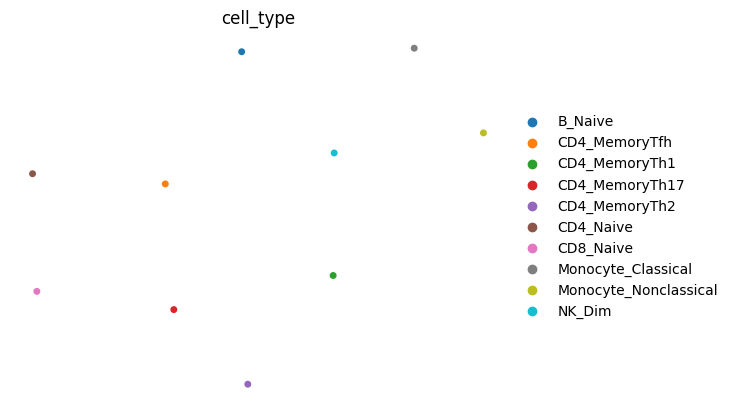

In [30]:
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4, size=100)

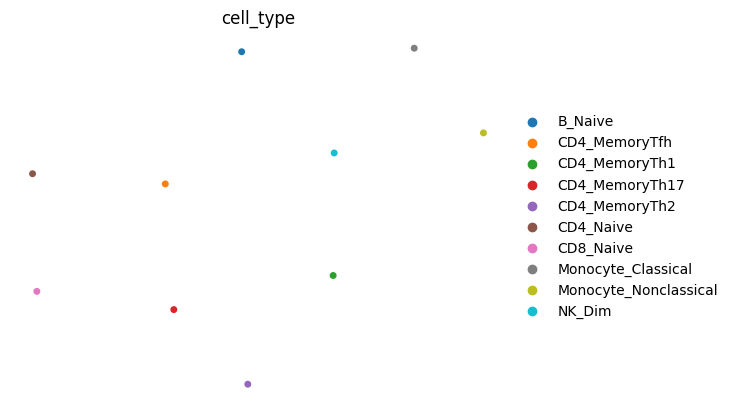

In [31]:
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4, size=100)

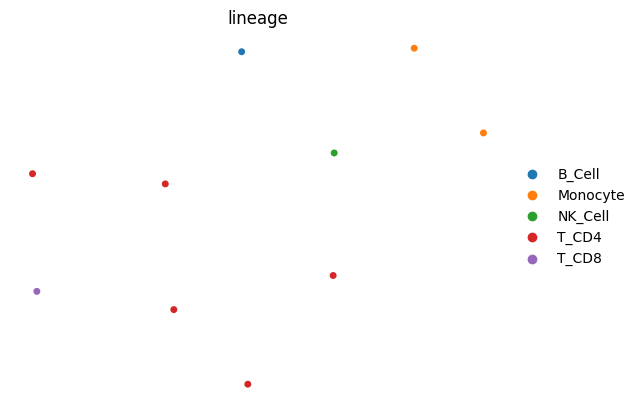

In [32]:
sc.pl.umap(ref_embed_adata, color="lineage", frameon=False, wspace=0.4, size=100)

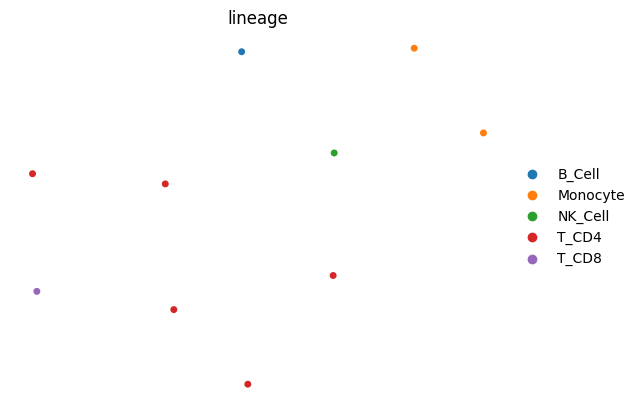

In [33]:
sc.pl.umap(ref_embed_adata, color="lineage", frameon=False, wspace=0.4, size=100)

In [36]:
# Save embeddings with metadata for later alignment with text embeddings
import pickle
from datetime import datetime

# Create a comprehensive data structure with embeddings and metadata
embeddings_data = {
    'embeddings_dict': embeddings_dict,  # Dict of embeddings by dataset
    'all_embeddings': all_embeddings,     # Concatenated embeddings
    'metadata': {}
}

# For each dataset, save the metadata
for dset in adata_dict:
    adata = adata_dict[dset]
    
    embeddings_data['metadata'][dset] = {
        'cell_ids': adata.obs.index.tolist(),  # Cell identifiers
        'cell_types': adata.obs[cell_type_key].tolist(),  # Cell type labels
        'lineage': adata.obs['lineage'].tolist() if 'lineage' in adata.obs else None,
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'gene_names': adata.var.index.tolist(),  # Gene names used
        'embedding_shape': embeddings_dict[dset].shape
    }

# Also save combined metadata
embeddings_data['combined_metadata'] = {
    'cell_ids': combined.obs.index.tolist(),
    'cell_types': combined.obs[cell_type_key].tolist(),
    'lineage': combined.obs['lineage'].tolist() if 'lineage' in combined.obs else None,
    'dataset_labels': combined.obs['batch'].tolist() if 'batch' in combined.obs else None,
    'total_cells': combined.n_obs,
    'embedding_shape': all_embeddings.shape
}

# Save to file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f"{folder}/scGPT_embeddings_with_metadata_{timestamp}.pkl"

with open(output_file, 'wb') as f:
    pickle.dump(embeddings_data, f)

print(f"Saved embeddings and metadata to: {output_file}")
print(f"\nStructure:")
print(f"  - embeddings_dict: {len(embeddings_dict)} datasets")
print(f"  - all_embeddings shape: {all_embeddings.shape}")
print(f"  - metadata: per-dataset cell IDs, cell types, lineage, gene names")
print(f"  - combined_metadata: combined cell IDs, cell types, lineage")

Saved embeddings and metadata to: /Users/vedran/Documents/scpgpt-project//scGPT_embeddings_with_metadata_20251106_102213.pkl

Structure:
  - embeddings_dict: 4 datasets
  - all_embeddings shape: (281, 512)
  - metadata: per-dataset cell IDs, cell types, lineage, gene names
  - combined_metadata: combined cell IDs, cell types, lineage
